<a href="https://colab.research.google.com/github/Royya9/CSIR/blob/master/CSIR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**We are doing this assignment in two parts. Sentiment Analysis and then training word2vec model**

**First part is to scrape HIV related article links from Times of India and do sentiment analysis on each of these articles using Microsoft Azure Cognitive Analytics API (free subscription)**

In [46]:
!pip install tika


**Loading required libraries for using Micorsoft Azure API**

In [0]:
import requests
import pprint

import urllib.request
import urllib.response
import sys
import os, glob
import tika
from tika import parser
import http.client, urllib
import json
import re
tika.initVM()

**Loading Azure access key (obtained from free subscription) and Azure URL data**

In [0]:
accessKey = '372e1a5e8145495cabacee488ac232e7'
Azure_url = 'australiaeast.api.cognitive.microsoft.com'
path = '/text/analytics/v2.0/Sentiment'
 
def TextAnalytics(documents):          # Function to connect to MS Azure API and passing article text in json format as input for Sentiment Analysis
    headers = {'Ocp-Apim-Subscription-Key': accessKey}
    conn = http.client.HTTPSConnection(Azure_url)
    body = json.dumps (documents)
    conn.request ("POST", path, body, headers)
    response = conn.getresponse ()
    return response.read ()

In [0]:
def parseTXT(corpus):          # Function to convert our articles' text in to json format required by MS Azure
    documents = { 'documents': []}
    count = 1
    
    text = corpus.strip('\n')
    text = text.encode('ascii','ignore').decode('ascii')

    documents.setdefault('documents').append({"language":"en","id":str(count),"text":text})
    count+= 1
    
    return documents

**Web Scraping and storing links in csv files**

In [0]:
import requests            
from bs4 import BeautifulSoup
import csv

# Our new website URL
TimesURL = 'https://timesofindia.indiatimes.com'

# Search URL which yeilds results from TOI website
Search_url = requests.get('https://timesofindia.indiatimes.com/topic/HIV')
source = BeautifulSoup(Search_url.text, 'html.parser')

pages = source.find_all('a', class_ = 'look')

All_url = []
results = []
dates = []

corpus_raw = u""

page_id, link_id = (0,0)

#
# Storing all search page links (which contain HIV related articles) in pages.csv Obtained 33 pages containing HIV related articles with 19 links per page on average
#

for page in pages:
  All_url.append(TimesURL + page['href'])
  row = [page_id+1, TimesURL + page['href']]

  with open('pages.csv', 'w+') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(row)
  page_id+= 1
  
csvFile.close()



#
# Getting individual article links from each search page and storing them in pages.csv 
#

for each_url in All_url:
  #print(each_url)
  my_url = requests.get(str(each_url))
  source = BeautifulSoup(my_url.text, 'html.parser')
  
  
  post_feed = source.find_all('li', class_ = 'article')

  for post in post_feed:
    title = post.find('div', class_ = 'content')
    date = title.find('span', class_ = 'meta')
    dates.append(date.text)
    for url in title.find_all('a', href = True):
      results.append(TimesURL + url['href'])

      

**Now extracting text from each article and doing sentiment analysis for each article. We are storing the link id, link URL and its sentiment score given by Azure (on a 0-1 scale) in Analysis.csv**

In [0]:
with open('Analysis.csv', 'w+') as csvFile:
  row = ['Link ID', 'URL', 'Sentiment Score']
  writer = csv.writer(csvFile)
  writer.writerow(row)

#
# Scraping data from 620 articles and storing all these articles' content text in corpus_raw. On a side note, observed that 2 articles links are dead
#

j = 0
for selected_link in results:
  results_url = selected_link 
   
  result = requests.get(results_url)
  result_text = BeautifulSoup(result.text)         # Using BeautifulSoup for pulling data from html
  extract_text = result_text.find('div', class_='Normal') # Some articles' text is contained in this html tag
  if extract_text is None:
    extract_text = result_text.find('span', class_='readmore_span')   # Some articles' text is contained in this html tag
  
  if extract_text is None:
    extract_text = result_text.find('div', class_ = 'section1')         # Some articles' text is contained in this html tag
  
  if extract_text is None:
    continue                        # Skipping dead links
    
  if extract_text is not None:
    j = j+1
    final_text = extract_text.get_text()
    corpus_raw+= final_text
    
    docs = parseTXT(final_text)     # Parsing text in json format readable by Microsot Azure Cognitive Analytics
    result = TextAnalytics (docs)   # result obtained in json format by Text Analytics from MS Azure
    
    
    final = json.loads(result)      # final result converted to dictionary format from json format returned by MS Azure
    if len(final['documents']) is 0:       # Microsoft Azure doesn't give sentiment scores with articles having a large text. So we are skipping them.
      continue
    score = final['documents'][0]['score']   # location of sentiment score 
    
    row = [j, selected_link, score]     # Writing all this data into Analysis.csv
    with open('Analysis.csv', 'a') as csvFile:
      writer = csv.writer(csvFile)
      writer.writerow(row)

csvFile.close()

**Now to analyze our Analysis.csv file for articles with Max and Min Sentiment values**

In [125]:
import csv

link_max = ''
link_min = ''

link_max_score = 0
link_min_score = 1

i = 0 
row_count = 0
total_sentiment = 0

sentiments_ = []

with open('Analysis.csv', 'r') as csvFile:
  reader = csv.reader(csvFile)
  
  for row in reader:
    
    if i is 0:
      i+= 1  # Skipping the very first row which contains headings
      continue
    
    row_count+= 1
    total_sentiment+= float(row[2])
    
    sentiments_.append(float(row[2]))
    if float(row[2]) > link_max_score:
      link_max = row[1]
      link_max_score = float(row[2])
      
    if float(row[2]) < link_min_score:
      link_min = row[1]
      link_min_score = float(row[2])
      
csvFile.close()

Average_Sentiment = (total_sentiment/row_count)

print('Article with most positive sentiment from our article list is ', link_max, ' and its sentiment score is ', link_max_score)

print('Article with most negative sentiment from our article list is ', link_min, ' and its sentiment score is ', link_min_score)

print('Average sentiment for all the HIV related articles from Times of India is ', Average_Sentiment)



Article with most positive sentiment from our article list is  https://timesofindia.indiatimes.com/entertainment/telugu/movies/news/samantha-turns-into-a-true-santa-for-hiv-affected-kids/articleshow/67254900.cms  and its sentiment score is  0.9834147691726685
Article with most negative sentiment from our article list is  https://timesofindia.indiatimes.com/city/surat/hiv-positive-man-gets-10-years-in-jail-for-raping-minor-stepdaughter/articleshow/66493248.cms  and its sentiment score is  0.008519262075424194
Average sentiment for all the HIV related articles from Times of India is  0.44037165030155306


**Now to plot our Sentiment values distribution across all our articles, we observe that majority of the sentiments are neutral**



Text(0,0.5,'Number of Articles')

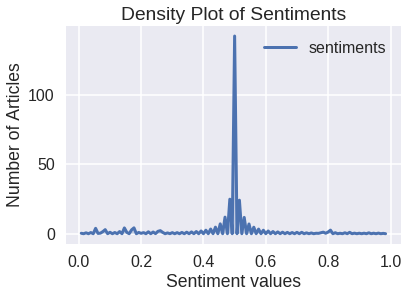

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.distplot(sentiments_, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = 'sentiments')

plt.title('Density Plot of Sentiments')
plt.xlabel('Sentiment values')
plt.ylabel('Number of Articles')

**Now second part is to vectorization of the words using gensim word2vec to plot words in our corpus and understand their contexts and extract similarities**

**Importing required libraries**

In [0]:
from __future__ import absolute_import, division, print_function

import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

  


**Enabling Logging**

In [0]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Downloading NLTK Tokenizer models**

In [67]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Splitting the corpus in to sentences**

In [0]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [0]:
raw_sentences = tokenizer.tokenize(corpus_raw)

**converting these sentences into a list of words  while removing unnnecessary punctuations, hyphens etc**

In [0]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [0]:
#sentence where each word is tokenized

sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [72]:
# Printing a random sentence 

print(raw_sentences[501])
print(sentence_to_wordlist(raw_sentences[501]))
#print(sentences)

“Earlier, 1000 new cases were identified every month, but they have now reduced to under 100,” she added.
['Earlier', 'new', 'cases', 'were', 'identified', 'every', 'month', 'but', 'they', 'have', 'now', 'reduced', 'to', 'under', 'she', 'added']


In [73]:
token_count = sum([len(sentence) for sentence in sentences])
print("The entire corpus contains {0:,} tokens".format(token_count))

The entire corpus contains 778,728 tokens


##**Train Word2Vec**

In [0]:

# Training word2vec with available vectors to understand words' DISTANCE, SIMILARITY, RANKING

# Choosing dimensionality of the resulting word vectors.
num_features = 500

# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [0]:

articles2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [76]:
articles2vec.build_vocab(sentences)

2019-01-08 17:30:25,462 : INFO : collecting all words and their counts
2019-01-08 17:30:25,464 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-01-08 17:30:25,522 : INFO : PROGRESS: at sentence #10000, processed 217883 words, keeping 7771 word types
2019-01-08 17:30:25,576 : INFO : PROGRESS: at sentence #20000, processed 436430 words, keeping 11199 word types
2019-01-08 17:30:25,627 : INFO : PROGRESS: at sentence #30000, processed 651979 words, keeping 12282 word types
2019-01-08 17:30:25,657 : INFO : collected 12282 word types from a corpus of 778728 raw words and 35876 sentences
2019-01-08 17:30:25,659 : INFO : Loading a fresh vocabulary
2019-01-08 17:30:25,683 : INFO : effective_min_count=3 retains 9406 unique words (76% of original 12282, drops 2876)
2019-01-08 17:30:25,684 : INFO : effective_min_count=3 leaves 772976 word corpus (99% of original 778728, drops 5752)
2019-01-08 17:30:25,710 : INFO : deleting the raw counts dictionary of 12282 items
201

In [77]:
print("Word2Vec vocabulary length:", len(articles2vec.wv.vocab))

Word2Vec vocabulary length: 9406


**Starting Training**

In [78]:
articles2vec.train(sentences, total_examples=len(sentences), epochs=10)

2019-01-08 17:30:34,394 : INFO : training model with 2 workers on 9406 vocabulary and 500 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2019-01-08 17:30:35,501 : INFO : EPOCH 1 - PROGRESS: at 11.50% examples, 64276 words/s, in_qsize 3, out_qsize 0
2019-01-08 17:30:36,571 : INFO : EPOCH 1 - PROGRESS: at 24.30% examples, 68485 words/s, in_qsize 3, out_qsize 0
2019-01-08 17:30:37,603 : INFO : EPOCH 1 - PROGRESS: at 37.06% examples, 70719 words/s, in_qsize 3, out_qsize 0
2019-01-08 17:30:38,646 : INFO : EPOCH 1 - PROGRESS: at 49.80% examples, 71684 words/s, in_qsize 3, out_qsize 0
2019-01-08 17:30:39,662 : INFO : EPOCH 1 - PROGRESS: at 62.60% examples, 72201 words/s, in_qsize 3, out_qsize 0
2019-01-08 17:30:40,690 : INFO : EPOCH 1 - PROGRESS: at 75.65% examples, 72708 words/s, in_qsize 3, out_qsize 0
2019-01-08 17:30:41,751 : INFO : EPOCH 1 - PROGRESS: at 89.55% examples, 73542 words/s, in_qsize 3, out_qsize 0
2019-01-08 17:30:42,495 : INFO : worker thread finished; awaiting f

(6015593, 7787280)

**Saving our model to file**

In [0]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [81]:
articles2vec.save(os.path.join("trained", "articles2vec.w2v"))

2019-01-08 17:32:51,057 : INFO : saving Word2Vec object under trained/articles2vec.w2v, separately None
2019-01-08 17:32:51,058 : INFO : not storing attribute vectors_norm
2019-01-08 17:32:51,060 : INFO : not storing attribute cum_table
2019-01-08 17:32:51,427 : INFO : saved trained/articles2vec.w2v


**Exploring the trained model**

In [82]:
articles2vec = w2v.Word2Vec.load(os.path.join("trained", "articles2vec.w2v"))

2019-01-08 17:32:55,172 : INFO : loading Word2Vec object from trained/articles2vec.w2v
2019-01-08 17:32:55,468 : INFO : loading wv recursively from trained/articles2vec.w2v.wv.* with mmap=None
2019-01-08 17:32:55,470 : INFO : setting ignored attribute vectors_norm to None
2019-01-08 17:32:55,473 : INFO : loading vocabulary recursively from trained/articles2vec.w2v.vocabulary.* with mmap=None
2019-01-08 17:32:55,474 : INFO : loading trainables recursively from trained/articles2vec.w2v.trainables.* with mmap=None
2019-01-08 17:32:55,476 : INFO : setting ignored attribute cum_table to None
2019-01-08 17:32:55,477 : INFO : loaded trained/articles2vec.w2v


**Compressing the word vectors into 2D space to plot them**

In [0]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [0]:
all_word_vectors_matrix = articles2vec.wv.vectors

**Training t-SNE**

In [0]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [0]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[articles2vec.wv.vocab[word].index])
            for word in articles2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [87]:
points.head(100)

,word,x,y
0,I,-36.816727,-0.587560
1,was,-30.431070,8.746008
2,only,-54.146008,-34.270851
3,with,-12.844620,-11.245491
4,a,-19.844790,-10.895104
5,head,7.813305,64.465813
6,full,-29.266237,-0.443058
7,of,6.095654,-7.568244
8,dreams,-9.695387,81.439484
9,when,-35.438992,27.692564


**Plotting the big picture**

In [0]:
sns.set_context("poster")

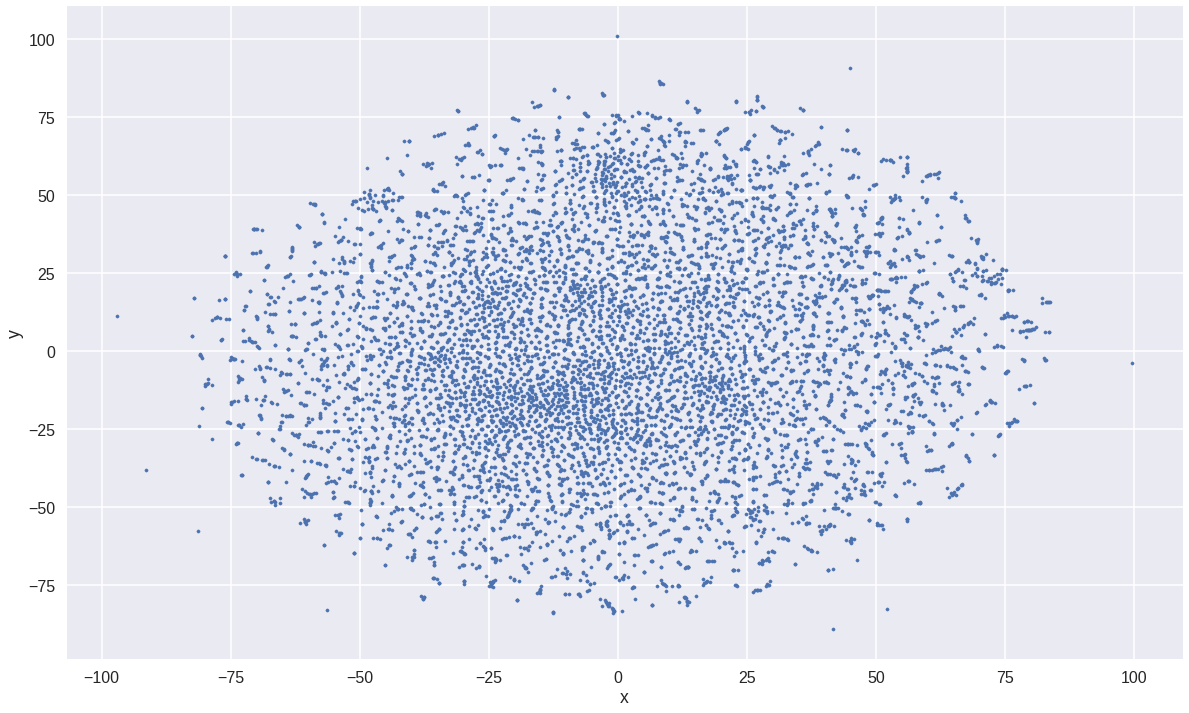

In [89]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [90]:
# Words similiar to 'blood'
articles2vec.wv.most_similar("blood")

2019-01-08 17:37:21,791 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('transfusion', 0.5419735312461853),
 ('bank', 0.5282109975814819),
 ('donated', 0.5126305222511292),
 ('disqualify', 0.5043641328811646),
 ('realising', 0.46675974130630493),
 ('NBTC', 0.46034836769104004),
 ('transfused', 0.46018508076667786),
 ('catastrophe', 0.45984947681427),
 ('antinatal', 0.45966365933418274),
 ('negligible', 0.45820701122283936)]

In [91]:
# Words similar to 'death'
articles2vec.wv.most_similar("death")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('homicidal', 0.559814453125),
 ('sentenceWith', 0.5571423172950745),
 ('penalty', 0.5431022047996521),
 ('imminent', 0.5332831144332886),
 ('suspicions', 0.5296438932418823),
 ('Observing', 0.5174335837364197),
 ('consequent', 0.509265661239624),
 ('declare', 0.5069783926010132),
 ('suspicious', 0.5010316967964172),
 ('suspicion', 0.49898165464401245)]

In [92]:
# Words similar to 'Andhra'
articles2vec.wv.most_similar("Andhra")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Telangana', 0.6980328559875488),
 ('AP', 0.6777563691139221),
 ('weather', 0.6547702550888062),
 ('northeastern', 0.652953565120697),
 ('Nagaland', 0.6516891121864319),
 ('Pradesh', 0.6440577507019043),
 ('Meghalaya', 0.6419479846954346),
 ('Supported', 0.6333385109901428),
 ('hitting', 0.6330963373184204),
 ('Jharkhand', 0.6124913692474365)]

**Zooming in to our main plot to observe interesting clusters**

In [0]:

def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**We can observe that words 'tended', 'humiliated', 'tuberculosis', 'cheated', 'ostracized' are grouped together on the right hand side at x = -25, y = 16**

**Similarly the words 'graduation', 'matriculate', 'disowned' are grouped in the centre at x = -28, y = 19 **

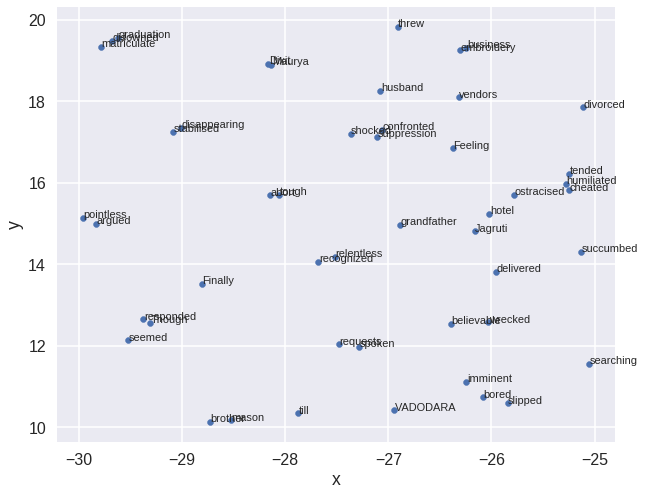

In [97]:
plot_region(x_bounds=(-30, -25), y_bounds=(10, 20))

**Linear relationships between word pairs**

In [0]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = articles2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [99]:
nearest_similarity_cosmul("HIV", "positive", "death")

HIV is related to positive, as disability is related to death


'disability'

In [110]:
nearest_similarity_cosmul("woman", "husband", "location")

woman is related to husband, as shop is related to location


'shop'

In [105]:
nearest_similarity_cosmul("HIV", "positive", "Andhra")

HIV is related to positive, as AP is related to Andhra


'AP'